In [1]:
library(rrBLUP)

# CMDSCALE

In [2]:
geno <-read.table("Hetero_realigned_cov10_filtered3.raw", row.names=1, header=T)
rownames(geno)<-1:240
pheno <- read.csv("2017heteroPheno.csv", header=T)
train_id<-read.csv("idtrain")
attach(pheno)
x <- as.matrix(geno)-1             #Convert geno file to matrix

In [8]:
d <- dist(x)                       #Construct genetic distance matrics
fit <- cmdscale(d,eig=TRUE, k=10)  #MDS analysis with 10 dimension 
pheno$F1 <- fit$points[,1]         #Dim1 score
pheno$F2 <- fit$points[,2]         #Dim2 score
pheno$F3 <- fit$points[,3]         #Dim3 score
DENS <- pheno$bcw/(pheno$length^2)     #Density

In [7]:
#plot(pheno[,c(10:12)])

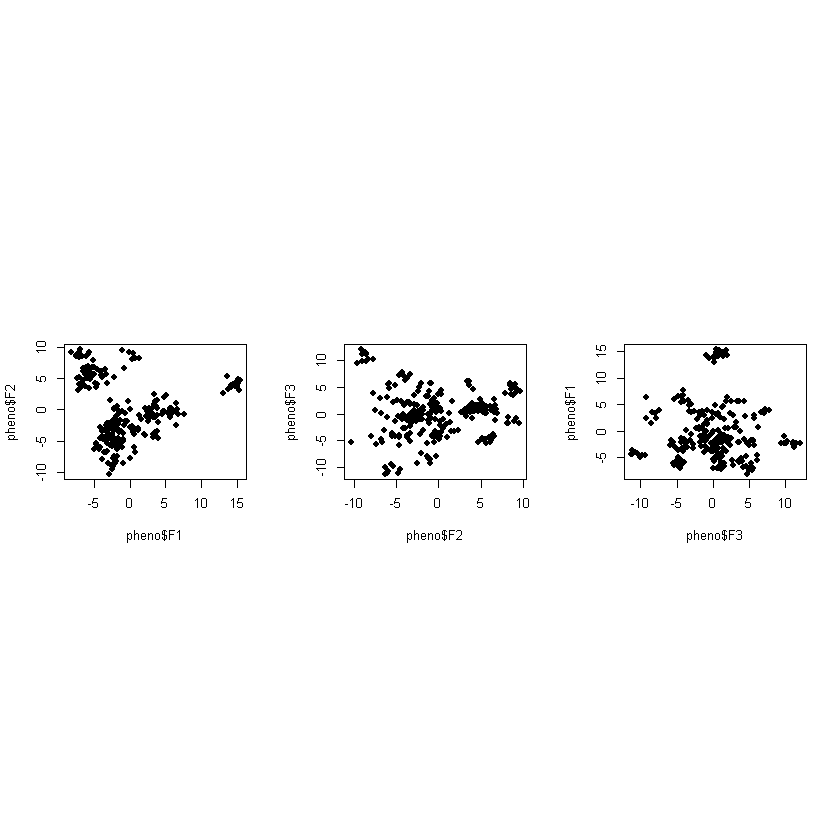

In [8]:
par(mfrow=c(1,3))
nf <- layout(matrix(c(1,2,3),ncol=3), widths=c(4,4,4), heights=c(4,4,4), TRUE)
plot(pheno$F1,pheno$F2, pch=19)
plot(pheno$F2,pheno$F3, pch=19)
plot(pheno$F3,pheno$F1, pch=19)

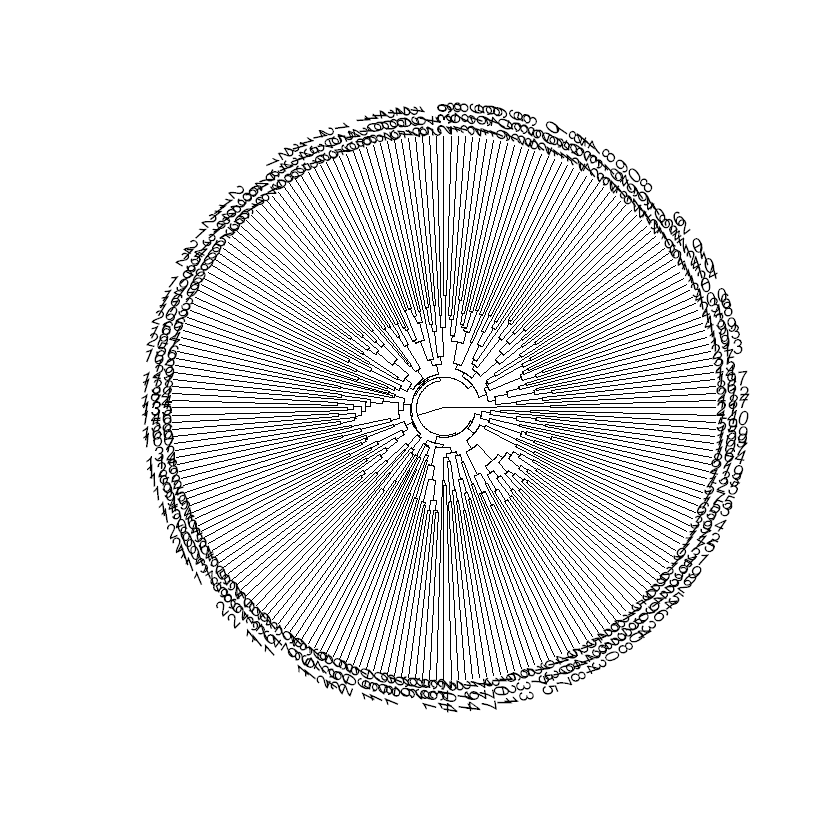

In [9]:
hcl <- hclust(d)
library(ape)
plot(as.phylo(hcl), type = "fan")

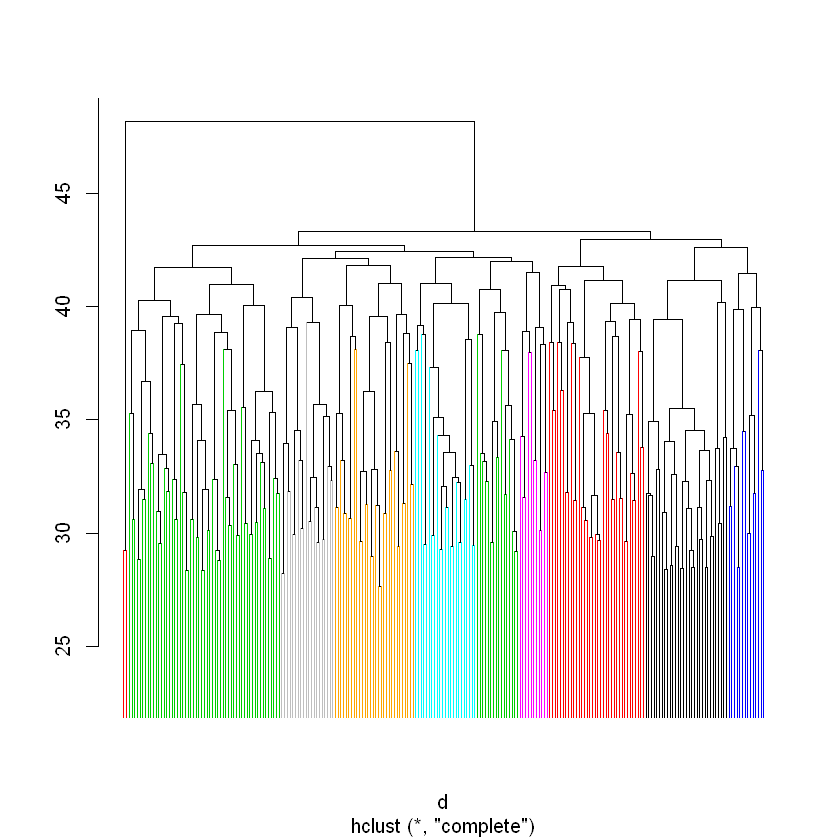

In [17]:
library(sparcl)
y = cutree(hcl, 10)
ColorDendrogram(hcl, y = y, labels = , main = "", 
    branchlength =60 )

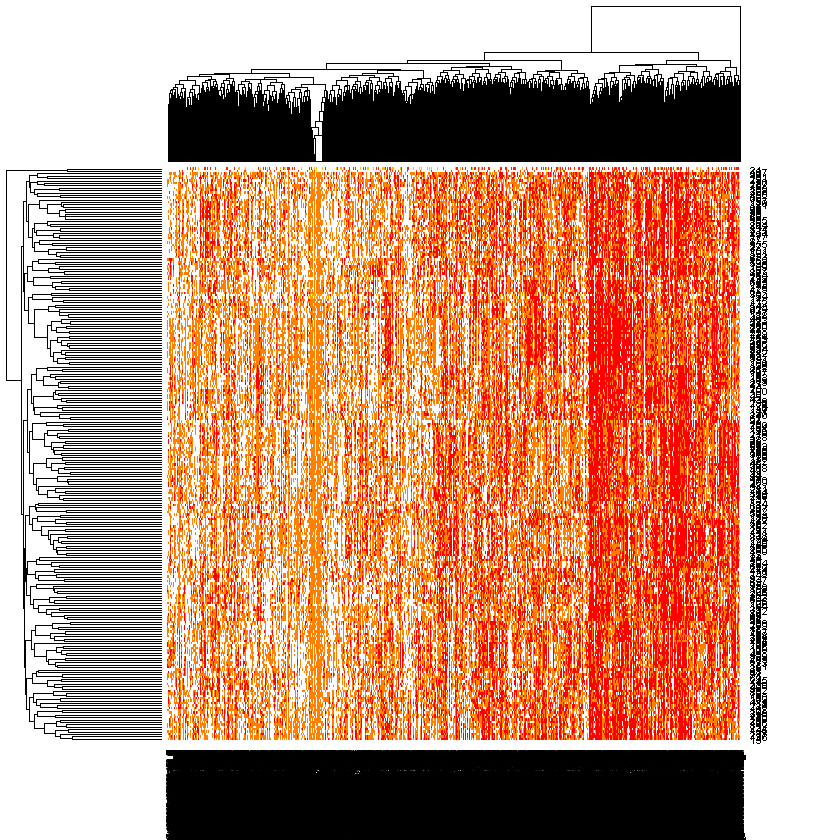

In [18]:
heatmap(as.matrix(x))

# BLUP

# 1.bcw

In [9]:
data <- data.frame(bcw=pheno$bcw,tank=pheno$tank,length=pheno$length,DENS=DENS,gid=1:240)
A <- A.mat(x, n.core=12)
row.names(A)=1:240
colnames(A)=1:240
M=A

In [49]:
ans_bcw <- kin.blup(data,geno="gid", pheno="bcw",K=M)

In [50]:
pheno$gebvbcw <- as.vector(ans_bcw$g)

In [51]:
#heribility
(h2_bcw <- ans_bcw$Vg/(ans_bcw$Vg+ans_bcw$Ve))                               
#Correlation between pred and obs
(cor_bcw = cor(pheno$gebvbcw,pheno$bcw))  
#Accuracy
(Acc_bcw = cor_bcw/sqrt(h2_bcw))                                   

[1] 0.5642543

[1] 0.8697462

[1] 1.157857

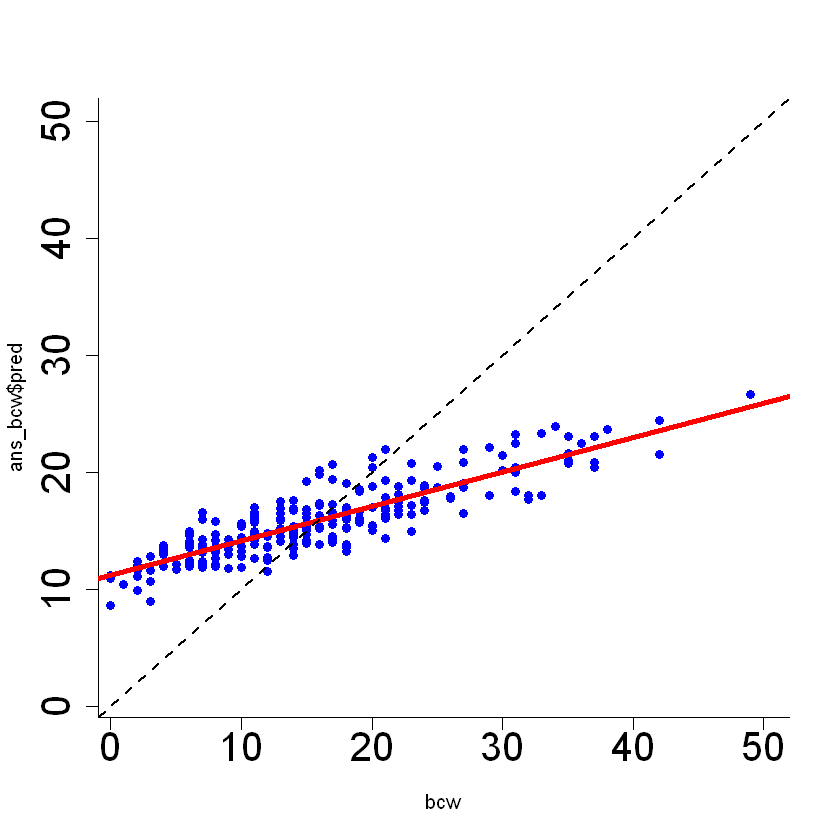

In [52]:
plot(bcw,ans_bcw$pred, pch = 16, cex = 1, col = "blue",bty="L",xlim=c(1,50),ylim=c(1,50),cex.axis = 2)
abline(lm(ans_bcw$pred ~ bcw),col = "red",lwd=4)
abline(a=0,b=1,lty = 2,lwd=2)

# 2.length

In [53]:
ans_length <- kin.blup(data,geno="gid",pheno="length",K = M)
pheno$gebvlength <- as.vector(ans_length$g)

In [54]:
(h2_length <- ans_length$Vg/(ans_length$Vg+ans_length$Ve))
#Correlation between pred and obs
(cor_length = cor(pheno$gebvlength,pheno$length))  
#Accuracy
(Acc_length = cor_length/sqrt(h2_length))   

[1] 0.868669

[1] 0.974252

[1] 1.045308

# 3.density

In [59]:
ans_DENS <- kin.blup(data,K=M,geno="gid", pheno="DENS")
pheno$gebvDENS <- as.vector(ans_DENS$g)

In [60]:
(h2_DENS <- ans_DENS$Vg/(ans_DENS$Vg+ans_DENS$Ve))                               
#Correlation between pred and obs
(cor_DENS = cor(pheno$gebvDENS,DENS))  
#Accuracy
(Acc_DENS = cor_DENS/sqrt(h2_DENS))   

[1] 0.5566609

[1] 0.885937

[1] 1.187429

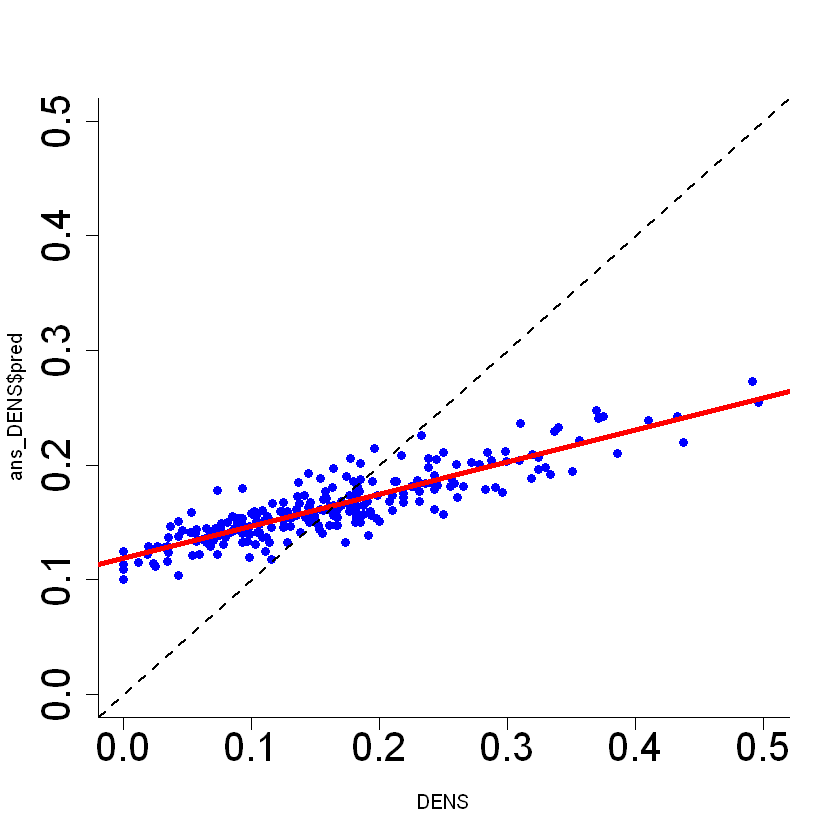

In [61]:
plot(DENS,ans_DENS$pred, pch = 16, cex = 1, col = "blue",bty="L",,xlim=c(0,0.5),ylim=c(0,0.5),cex.axis = 2)
abline(lm(ans_DENS$pred ~ DENS),col = "red",lwd=4)
abline(a=0,b=1,lty = 2,lwd=2)

# plot

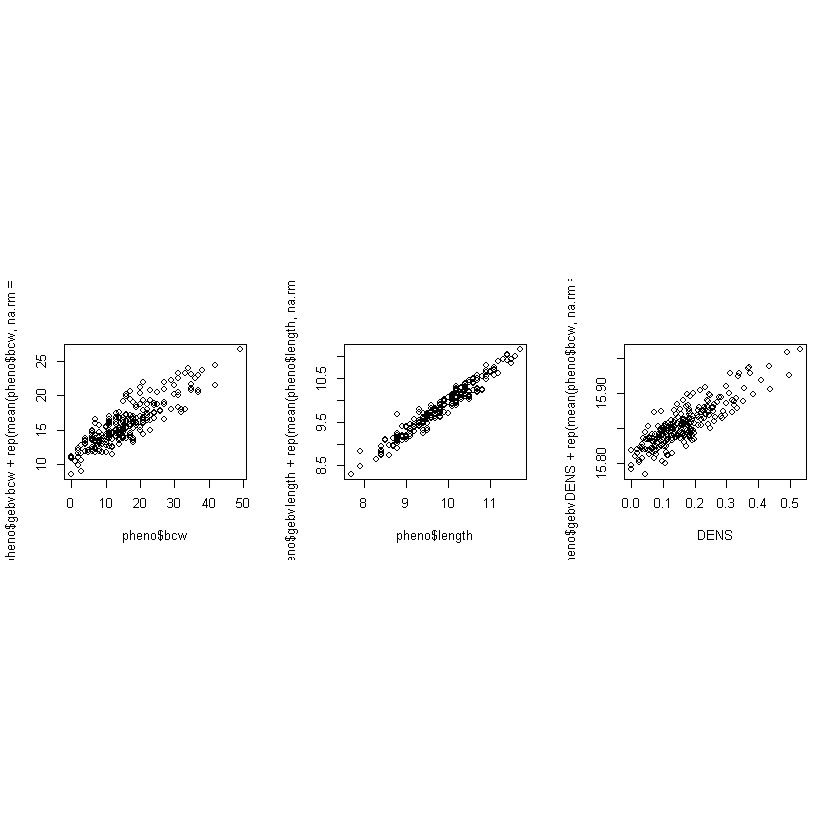

In [34]:
par(mfrow=c(1,3))
nf <- layout(matrix(c(1,2,3),ncol=3), widths=c(4,4,4), heights=c(4,4,4), TRUE)
plot((pheno$gebvbcw + rep(mean(pheno$bcw, na.rm=T))) ~ pheno$bcw)
plot((pheno$gebvlength + rep(mean(pheno$length, na.rm=T))) ~ pheno$length)
plot((pheno$gebvDENS + rep(mean(pheno$bcw, na.rm=T))) ~ DENS)

# 4

In [ ]:
blup <- kin.blup(, K=M, geno="gid", pheno="bcw", fix="tank")


# 5 folds cross-validation

In [111]:
repeats <-5
n.fold <- 5    # 5 folds cross-validation
accbcw <- data.frame(matrix(rep(NA,n.fold*repeats), nrow=n.fold, ncol=repeats))
h2bcw <- data.frame(matrix(rep(NA,n.fold*repeats), nrow=n.fold, ncol=repeats))
for(j in 1:repeats) {
  n.sample <- length(pheno$bcw)            #171samples
  set.seed(100+3*j+1)
  id <- sample(1:n.sample %% n.fold) + 1    # generate random ids
  for(i in 1:n.fold) {
    bcw_test <- data
    test <- id == i
    bcw_test$bcw[test] <- NA
    res <- kin.blup(bcw_test, K=M, geno="gid", pheno="bcw",fix="length")
    h2=res$Vg/(res$Vg+res$Ve)
    accbcw[i,j] <- (cor(pheno$bcw[id==i],res$g[id==i])/sqrt(h2))
    h2bcw[i,j] <- h2
  }
}

write.table(accbcw, "./5-fold_CV_10times_repeats_bcw_Train-Train",quote=F, col.names=F, row.names=F, sep="\t")
#5-fold CV x 10times
(accbcw_mean <- apply(accbcw, 2, mean))
#mean
(meanbcw <- mean(accbcw_mean))                
#se
(SEbcw <- sd(accbcw_mean)/sqrt(repeats-1))    


X1        X2        X3        X4        X5 
0.3591143 0.4710430 0.1850370 0.3341189 0.3293941

[1] 0.3357415

[1] 0.05099483

In [107]:
repeats <-5
n.fold <- 5    # 5 folds cross-validation
accbcw <- data.frame(matrix(rep(NA,n.fold*repeats), nrow=n.fold, ncol=repeats))
h2bcw <- data.frame(matrix(rep(NA,n.fold*repeats), nrow=n.fold, ncol=repeats))
for(j in 1:repeats) {
  n.sample <- length(pheno$bcw)            #171samples
  set.seed(100+3*j+1)
  id <- sample(1:n.sample %% n.fold) + 1    # generate random ids
  for(i in 1:n.fold) {
    bcw_test <- data
    test <- id == i
    bcw_test$DENS[test] <- NA
    res <- kin.blup(bcw_test, K=M, geno="gid", pheno="DENS")
    h2=res$Vg/(res$Vg+res$Ve)
    accbcw[i,j] <- (cor(data$DENS[id==i],res$g[id==i])/sqrt(h2))
    h2bcw[i,j] <- h2
  }
}

write.table(accbcw, "./5-fold_CV_10times_repeats_bcw_Train-Train",quote=F, col.names=F, row.names=F, sep="\t")
#5-fold CV x 10times
(accbcw_mean <- apply(accbcw, 2, mean))
#mean
(meanbcw <- mean(accbcw_mean))                
#se
(SEbcw <- sd(accbcw_mean)/sqrt(repeats-1))    


X1        X2        X3        X4        X5 
0.3347335 0.3073621 0.1973008 0.2449720 0.2651024

[1] 0.2698942

[1] 0.02683499

# GWAS

In [1]:
lin_map<-read.table("lin.map")

In [16]:
g <- data.frame(rownames(lin_map),lin_map$V1, lin_map$V2, t(x))
rownames(g) <-1:nrow(g)
colnames(g) <-c("marker", "chrom", "pos", rownames(x))

In [17]:
bcw <-data.frame(1:240, pheno$bcw)
colnames(bcw) <-c("gid", "bcw")
rownames(x) <-1:240
colnames(x) <-1:3928
# perform GWAS with the GWAS function in the rrBLUP package
GWAS_bcw <-GWAS(bcw, g,K=M, n.PC = 10) 

[1] "GWAS for trait: bcw"
[1] "Variance components estimated. Testing markers."


In [14]:
length <-data.frame(rownames(x), pheno$length)
colnames(length) <-c("ID", "length")
#colnames(amat2) <-rownames(amat2) <-rownames(x)
# perform GWAS with the GWAS function in the rrBLUP package
GWAS_length <-GWAS(length, g, K = M, n.PC = 10, fix=pheno$Tank) 

[1] "GWAS for trait: length"
[1] "Variance components estimated. Testing markers."


In [10]:
DENS <-data.frame(rownames(x), DENS)
colnames(DENS) <-c("ID", "DENS")
#colnames(amat2) <-rownames(amat2) <-rownames(x)
# perform GWAS with the GWAS function in the rrBLUP package
GWAS_DENS <-GWAS(DENS, g, K = M, n.PC = 10, fix=pheno$Tank) 

[1] "GWAS for trait: DENS"
[1] "Variance components estimated. Testing markers."


[1] 0.05

[1] 4.895201

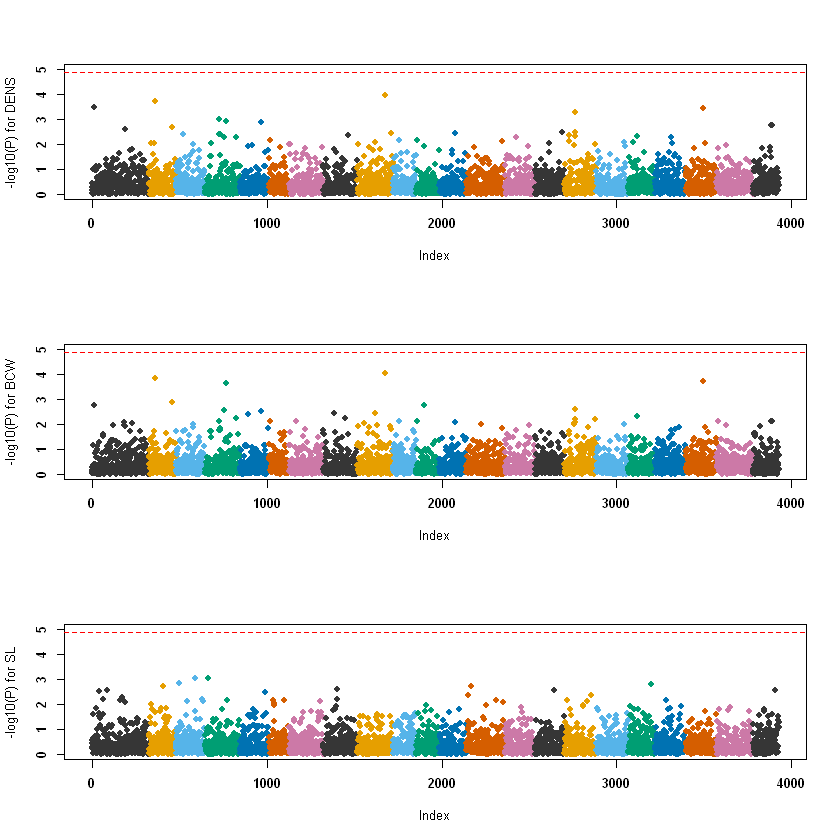

In [85]:
(Bnf <- p.adjust(0.05/nrow(g), "bonferroni", nrow(g)))
(thred <- -log10(0.05/nrow(g)))
cbPalette2 <- c("#363636", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7",
                "#363636", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7",
                "#363636", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7",
                "#363636", "#E69F00")

par(mfrow=c(3,1),font.axis = 2 )
plot(GWAS_DENS$DENS, col=cbPalette2[GWAS_DENS$chrom], pch=19, ylab="-log10(P) for DENS", ylim=c(0,5))

abline(h=thred, lty=2,col="red")
plot(GWAS_bcw$bcw, col=cbPalette2[GWAS_bcw$chrom], pch=19, ylab="-log10(P) for BCW", ylim=c(0,5))
abline(h=thred, lty=2,col="red")
plot(GWAS_length$length, col=cbPalette2[GWAS_length$chrom], pch=19, ylab="-log10(P) for SL", ylim=c(0,5))
abline(h=thred, lty=2,,col="red")

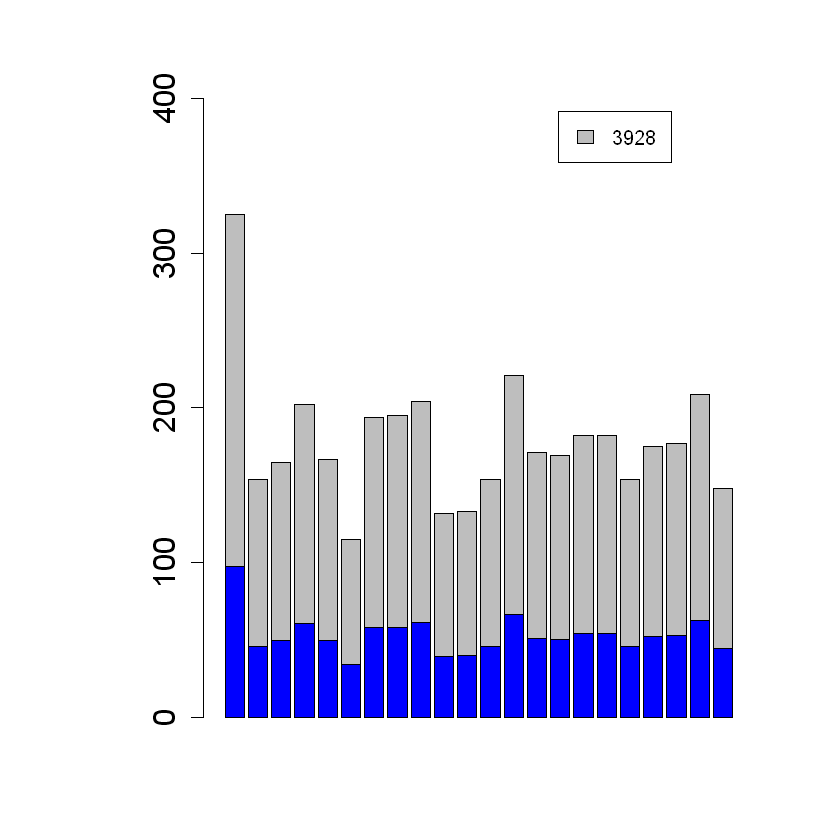

In [12]:
m=1:22
for(i in 1:22) {
m[i]=dim(lin_map[lin_map$V1==i,])[1]
}
nf <- layout(1,widths=3, heights=4, TRUE)
barplot(m, ,ylim=c(0,400),xlim=c(0,23),cex.axis = 1.5,legend = "3928",names.arg = )
par(new=TRUE)
barplot(m*0.3, ,ylim=c(0,400),xlim=c(0,23),col="blue",cex.axis = 1.5,names.arg = )

In [6]:
str

[1] 325 154 165 202 167 115 194 195 204 132 133 154 221 171 169 182 182 154 175
[20] 177 209 148

# snp minDP20

In [6]:
geno2 <-read.table("./vcftools_minDP20/Hetero_realigned_cov20_filtered3.raw",row.names=1, header=T)
lin_map2<-read.table("./vcftools_minDP20/lin.map")

In [7]:
str(geno2)

'data.frame':	240 obs. of  2873 variables:
 $ Chr_10.590671.590897.71_C     : int  0 1 1 0 0 0 0 0 1 0 ...
 $ Chr_4.10421204.10421428.71_A  : int  NA NA NA 1 1 NA 0 1 NA NA ...
 $ Chr_21.4492054.4492321.72_T   : int  1 NA NA 1 1 NA 1 NA 1 NA ...
 $ Chr_16.590706.590976.73_T     : int  0 1 NA 1 0 NA 1 1 1 1 ...
 $ Chr_12.7705383.7705656.74_G   : int  1 1 NA NA 1 NA NA 1 0 1 ...
 $ Chr_5.7062535.7062797.74_T    : int  NA 1 1 1 0 0 0 1 NA 0 ...
 $ Chr_3.346516.346786.75_G      : int  0 0 1 0 1 1 0 0 0 1 ...
 $ Chr_4.10031434.10031689.75_T  : int  1 1 1 1 NA 1 NA 1 1 1 ...
 $ Chr_7.10303617.10303846.75_G  : int  1 0 0 NA 0 0 0 0 1 0 ...
 $ Chr_18.2602650.2602898.75_T   : int  0 0 0 1 0 1 0 1 0 0 ...
 $ Chr_18.6833350.6833605.75_A   : int  NA 1 NA 1 NA NA 1 NA NA 1 ...
 $ Chr_18.6874710.6874972.75_T   : int  0 0 0 1 0 0 0 0 0 0 ...
 $ Chr_21.12412438.12412711.75_G : int  NA NA 1 1 NA NA 0 0 1 0 ...
 $ Chr_9.11378365.11378633.76_A  : int  1 NA NA NA 1 NA NA 1 1 0 ...
 $ Chr_2.5961126.5961388

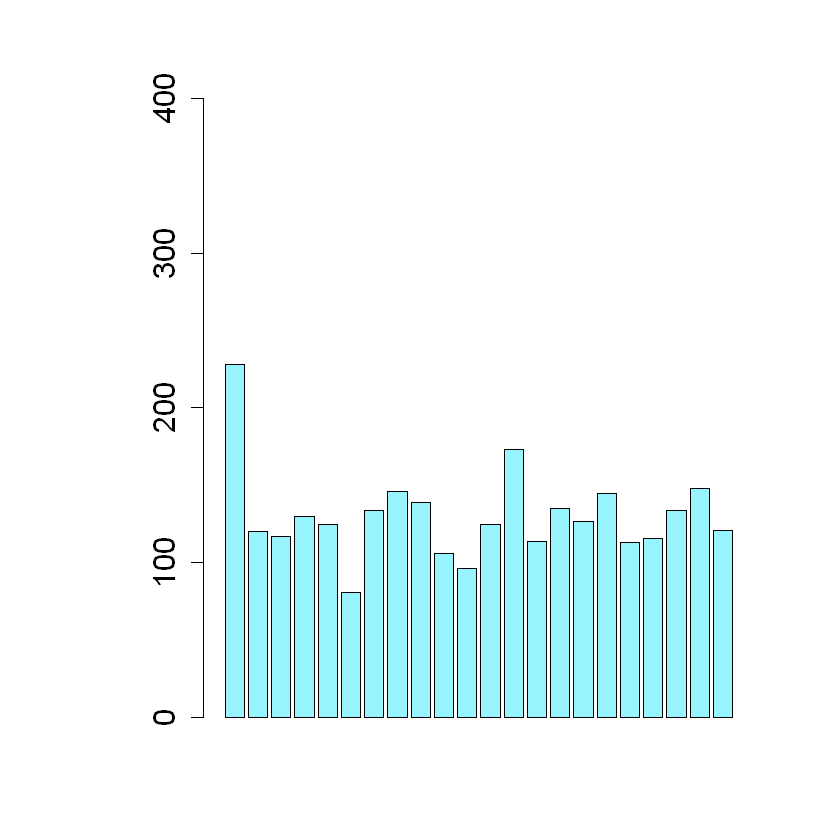

In [9]:
m=1:22
for(i in 1:22) {
m[i]=dim(lin_map2[lin_map2$V1==i,])[1]
}
nf <- layout(1,widths=3, heights=4, TRUE)
barplot(m,col = "cadetblue1",ylim=c(0,400),xlim=c(0,23),cex.axis = 1.5,names.arg = )